In [1]:
import numpy as np
import cv2
from pyproj import Transformer
from my_vbr_utils.vbr_dataset import VBRDataset, load_scene_calibration
from my_vbr_utils.utilities import load_scene_correspondences

# --- Config and Dataset Loading ---
# Set these variables to configure your scene and utility path
location = 'campus'
vbr_utils_root = '/home/bjangley/VPR/mast3r-v2/my_vbr_utils'

config_path = f'{vbr_utils_root}/vbrPaths.yaml'

# Load dataset and calibration
all_loaded = VBRDataset(config_path, locations=[location])
vbr_scene = all_loaded.get_combined_dataset()
calib = load_scene_calibration(location, config_path)

Loading scene: campus_train0
  KITTI path: /datasets/vbr_slam/campus/campus_train0_kitti
  GT path: /datasets/vbr_slam/campus/campus_train0/campus_train0_gt.txt
  ✓ Successfully loaded campus_train0
Loading scene: campus_train1
  KITTI path: /datasets/vbr_slam/campus/campus_train1_kitti
  GT path: /datasets/vbr_slam/campus/campus_train1/campus_train1_gt.txt
  ✓ Successfully loaded campus_train1
Loaded 2 training scenes: ['campus_train0', 'campus_train1']


In [2]:
print(vbr_scene.get_dataset_info())
print(len(vbr_scene))
calib = load_scene_calibration(location_name='spagna', config_path=config_path)
info = vbr_scene.get_dataset_info()

[{'dataset_index': 0, 'length': 12048, 'start_index': 0, 'end_index': 12047}, {'dataset_index': 1, 'length': 11677, 'start_index': 12048, 'end_index': 23724}]
23725


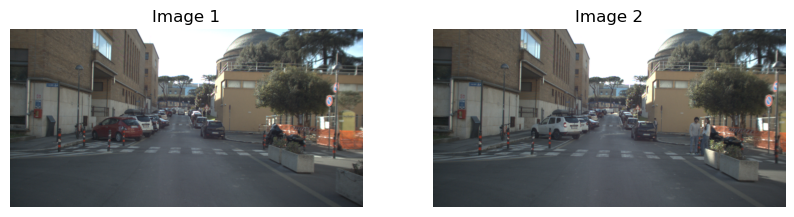

In [52]:
# sample1 = vbr_scene[1000]
# sample2 = vbr_scene[1001]

sample1 = vbr_scene[5178]
sample2 = vbr_scene[17042]

# sample1 = vbr_scene[8161]
# sample2 = vbr_scene[13020]
# # sample2 = vbr_scene[20935]

# sample1=vbr_scene[4971]
# sample2=vbr_scene[13743]
from PIL import Image
import matplotlib.pyplot as plt
img1 = Image.open(sample1['image'])
img2 = Image.open(sample2['image'])


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.show()

### For scenes with two training sequences - Campus, Ciampino

Verify using images and then load two LiDAR scans from samples close to each other (globally), perform ICP to find the transformation between the two samples, then align the local frame from `train0` to `train1`. 

In [54]:
import random
import open3d as o3d
import numpy as np
# Set random seeds for reproducibility
seed = 5  # or any integer you like
lidar1 = sample1['lidar_points']
lidar2 = sample2['lidar_points']

np.random.seed(seed)
random.seed(seed)
o3d.utility.random.seed(seed)  # Open3D's random seed (for RANSAC, etc.)
def remove_ground_plane(pcd, distance_threshold=0.7, ransac_n=10, num_iterations=1000):
    # Fit plane using RANSAC
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iterations)
    # Select everything that is NOT ground
    non_ground = pcd.select_by_index(inliers, invert=True)
    return non_ground

# Convert numpy arrays to Open3D point clouds
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(lidar1)
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(lidar2)

# Remove ground
pcd1_noground = remove_ground_plane(pcd1)
pcd2_noground = remove_ground_plane(pcd2)

# (Optional) Downsample for speed
# pcd1 = pcd1.voxel_down_sample(voxel_size=0.1)
# pcd2 = pcd2.voxel_down_sample(voxel_size=0.1)

# Estimate normals (optional, helps with point-to-plane ICP)
pcd1_noground.estimate_normals()
pcd2_noground.estimate_normals()

# Set a reasonable threshold for correspondence (in meters)
threshold = 0.5
init_trans = np.eye(4)

# Run ICP (point-to-point)
reg_p2p = o3d.pipelines.registration.registration_icp(
    pcd1_noground, pcd2_noground, threshold, init_trans,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000) # Specify max iterations
) #from pc1 to pc2

print("ICP transformation matrix:\n", reg_p2p.transformation)
print("ICP fitness:", reg_p2p.fitness)
print("ICP inlier RMSE:", reg_p2p.inlier_rmse)
transform=reg_p2p.transformation

from my_utils.transformations import pose_to_se3
pose1 = np.linalg.inv(pose_to_se3(sample1['pose'])) #local1_to_lidar1
pose2 = np.linalg.inv(pose_to_se3(sample2['pose'])) #local2_to_lidar2

transform = reg_p2p.transformation #lidar1_to_lidar2
local1_to_local2 = np.linalg.inv(pose2) @ transform @ pose1
print("Transformation Matrix (Local Frame Train0 to Local Frame Train1")
print(np.array2string(local1_to_local2, formatter={'float_kind': lambda x: f"{x:.6f}"}))
print(np.array2string(np.linalg.inv(local1_to_local2), formatter={'float_kind': lambda x: f"{x:.6f}"}))

ICP transformation matrix:
 [[ 9.99683373e-01  2.50325684e-02  2.55417389e-03 -9.90034075e-01]
 [-2.50309461e-02  9.99686455e-01 -6.65190853e-04  1.22576681e-01]
 [-2.57002447e-03  6.01046846e-04  9.99996517e-01  9.10271361e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ICP fitness: 0.8305580061755624
ICP inlier RMSE: 0.18092803115447542
Transformation Matrix (Local Frame Train0 to Local Frame Train1
[[-0.939320 -0.342816 -0.012437 195.253573]
 [0.342668 -0.939372 0.012581 -67.945888]
 [-0.015996 0.007555 0.999844 4.394702]
 [0.000000 0.000000 0.000000 1.000000]]
[[-0.939320 0.342668 -0.015996 206.758838]
 [-0.342816 -0.939372 0.007555 3.076377]
 [-0.012437 0.012581 0.999844 -1.110751]
 [0.000000 0.000000 0.000000 1.000000]]


[[-0.939550 -0.342200 -0.012026 195.391275]
 [0.341967 -0.939541 0.017934 -67.884867]
 [-0.017436 0.012737 0.999767 5.511270]
 [0.000000 0.000000 0.000000 1.000000]]

 [[-0.937124 -0.348081 -0.025267 194.990492]
 [0.347916 -0.937463 0.010810 -68.841191]
 [-0.027449 0.001339 0.999622 5.155712]
 [0.000000 0.000000 0.000000 1.000000]]

In [55]:
pose_1 = pose_to_se3(sample1['pose'])
pose_2 = pose_to_se3(sample2['pose'])
pose_3 = np.linalg.inv(local1_to_local2) @ pose_2
print(pose_1[:,3]-pose_3[:,3])




[-0.24017779  0.96807845 -0.02034981  0.        ]


In [56]:
# filepath: /home/bjangley/VPR/mast3r-v2/icp_campus.ipynb
print("Pose1:\n", np.array2string(pose_1, formatter={'float_kind': lambda x: f"{x:.8f}"}))
print("Pose2:\n", np.array2string(pose_2, formatter={'float_kind': lambda x: f"{x:.8f}"}))
print("ICP Transform:\n", np.array2string(transform, formatter={'float_kind': lambda x: f"{x:.8f}"}))
print("Local1 to Local2:\n", np.array2string(local1_to_local2, formatter={'float_kind': lambda x: f"{x:.8f}"}))
print("Pose3:\n", np.array2string(pose_3, formatter={'float_kind': lambda x: f"{x:.8f}"}))

Pose1:
 [[0.33473505 0.94229985 0.00484178 134.94061371]
 [-0.94196363 0.33446702 0.02891953 -181.11381716]
 [0.02563146 -0.01424117 0.99957002 0.05290502]
 [0.00000000 0.00000000 0.00000000 1.00000000]]
Pose2:
 [[-0.01691591 -0.99947823 -0.02751591 130.69520598]
 [0.99974388 -0.01649379 -0.01549637 149.41988854]
 [0.01503444 -0.02777100 0.99950124 0.92986602]
 [0.00000000 0.00000000 0.00000000 1.00000000]]
ICP Transform:
 [[0.99968337 0.02503257 0.00255417 -0.99003408]
 [-0.02503095 0.99968646 -0.00066519 0.12257668]
 [-0.00257002 0.00060105 0.99999652 0.00910271]
 [0.00000000 0.00000000 0.00000000 1.00000000]]
Local1 to Local2:
 [[-0.93932022 -0.34281604 -0.01243746 195.25357307]
 [0.34266842 -0.93937217 0.01258067 -67.94588755]
 [-0.01599626 0.00755535 0.99984351 4.39470242]
 [0.00000000 0.00000000 0.00000000 1.00000000]]
Pose3:
 [[0.35822962 0.93362244 0.00454786 135.18079151]
 [-0.93321894 0.35792116 0.03154133 -182.08189561]
 [0.02781992 -0.01554318 0.99949210 0.07325484]
 [0.000

In [42]:
pose_1 = pose_to_se3(sample1['pose'])
pose_2 = pose_to_se3(sample2['pose'])
transform = reg_p2p.transformation
pose_3 = np.linalg.inv(local1_to_local2) @ pose_2
print(pose_1[:,3]-pose_3[:,3])

print(pose_1)
print(pose_2)
print(pose_3)

[-0.20155324  0.11463049 -0.03971462  0.        ]
[[-9.09902237e-01  4.14779930e-01  5.96062183e-03  1.30265594e+02]
 [-4.14803817e-01 -9.09904066e-01 -3.51910140e-03 -1.44249084e+02]
 [ 3.96394141e-03 -5.67452693e-03  9.99976043e-01 -3.31931022e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.97043780e-01 -7.67767849e-02 -3.00450092e-03  1.20479346e+02]
 [ 7.68242107e-02  9.96805966e-01  2.18153073e-02  1.12405907e+02]
 [ 1.31999528e-03 -2.19816348e-02  9.99757503e-01  8.39609015e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.09829825e-01  4.14957913e-01  4.42941862e-03  1.30467148e+02]
 [-4.14973634e-01 -9.09826574e-01 -3.53379287e-03 -1.44363714e+02]
 [ 2.56362746e-03 -5.05324209e-03  9.99983946e-01 -2.92216399e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### Visualise LiDAR after Alignment

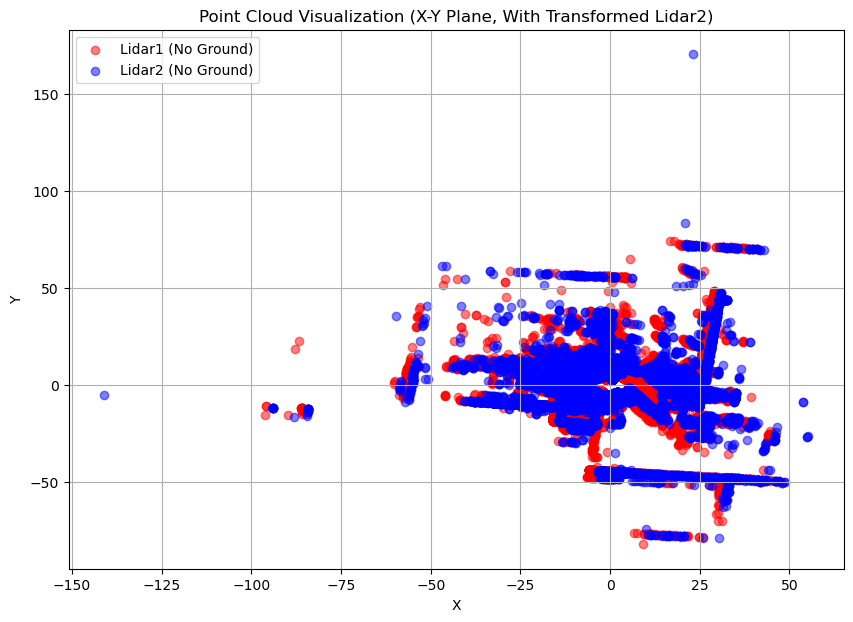

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Convert Open3D point clouds back to numpy arrays
lidar1_noground = np.asarray(pcd1_noground.points)
lidar2_noground = np.asarray(pcd2_noground.points)

# Convert lidar2_noground to homogeneous coordinates for transformation
ones = np.ones((lidar2_noground.shape[0], 1))
lidar2_hom = np.hstack([lidar2_noground, ones])  # Shape: (M, 4)
lidar2_transformed = (np.linalg.inv(transform) @ lidar2_hom.T).T[:, :3]


# Plot Lidar1, original Lidar2, and transformed Lidar2
plt.figure(figsize=(10, 7))
plt.scatter(lidar1_noground[:, 0], lidar1_noground[:, 1], c='r', label='Lidar1 (No Ground)', alpha=0.5)
plt.scatter(lidar2_noground[:, 0], lidar2_noground[:, 1], c='b', label='Lidar2 (No Ground)', alpha=0.5)
# plt.scatter(lidar2_transformed[:, 0], lidar2_transformed[:, 1], c='g', label='Lidar2 Transformed', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.title("Point Cloud Visualization (X-Y Plane, With Transformed Lidar2)")
plt.show()

### Make new ground truth for Train1
Align `<scene>_train1_gt.txt` to save poses in the local frame of `<scene>_train0_gt.txt`. 

In [9]:
# from my_utils.transformations import pose_to_se3, se3_to_pose
# gt_path = "/datasets/vbr_slam/campus/campus_train1/campus_train1_gt.txt"
# save_path = "/home/bjangley/VPR/mast3r-v2/my_vbr_utils/local_frame_alignment/campus_train1_gt.txt"
# local2_to_local1 = np.linalg.inv(local1_to_local2)

# import os
# import numpy as np
# from my_utils.transformations import pose_to_se3, se3_to_pose

# def ensure_dir_exists(path):
#     """
#     Ensure the directory for the given path exists.
#     """
#     dirpath = os.path.dirname(path)
#     if dirpath and not os.path.exists(dirpath):
#         os.makedirs(dirpath)

# def read_ground_truth_file(gt_path):
#     """
#     Read the ground truth file and extract timestamps, poses, and the header.
#     """
#     timestamps = []
#     poses = []
#     header = ""
#     with open(gt_path, 'r') as f:
#         lines = f.readlines()
#         # Check if the first line is a header (non-numeric)
#         if not lines[0].strip().split()[0].replace('.', '', 1).isdigit():
#             header = lines[0].strip()
#             lines = lines[1:]  # Skip the header line
#         for line in lines:
#             parts = line.strip().split()
#             if len(parts) == 8:  # Ensure the line has the correct format
#                 timestamps.append(float(parts[0]))
#                 tx, ty, tz, qx, qy, qz, qw = map(float, parts[1:])
#                 poses.append((tx, ty, tz, qx, qy, qz, qw))
#     return timestamps, poses, header

# def write_transformed_ground_truth_file(save_path, timestamps, transformed_poses, header=""):
#     """
#     Write the transformed ground truth file with timestamps and poses.
#     """
#     ensure_dir_exists(save_path)  # Ensure the directory exists
#     with open(save_path, 'w') as f:
#         # Write the header if provided
#         if header:
#             f.write(header + "\n")
#         # Write the transformed poses
#         for timestamp, pose in zip(timestamps, transformed_poses):
#             tx, ty, tz, qx, qy, qz, qw = pose
#             f.write(f"{timestamp:.10f} {tx:.6f} {ty:.6f} {tz:.6f} {qx:.6f} {qy:.6f} {qz:.6f} {qw:.6f}\n")

# def apply_transformation_to_poses(poses, transform):
#     """
#     Apply the local2_to_local1 transformation to the poses.
#     """
#     transformed_poses = []
#     for tx, ty, tz, qx, qy, qz, qw in poses:
#         # Convert pose to SE(3) matrix
#         pose_matrix = pose_to_se3([tx, ty, tz, qx, qy, qz, qw])
        
#         # Apply the transformation
#         transformed_matrix = transform @ pose_matrix
        
#         # Convert back to pose format
#         transformed_pose = se3_to_pose(transformed_matrix)
#         transformed_poses.append(transformed_pose)
#     return transformed_poses

# # Read the ground truth file
# timestamps, poses, header = read_ground_truth_file(gt_path)

# # Apply the transformation
# transformed_poses = apply_transformation_to_poses(poses, local2_to_local1)

# # Write the transformed ground truth file
# # write_transformed_ground_truth_file(save_path, timestamps, transformed_poses, header)

# # print(f"Transformed ground truth file saved to {save_path}")

In [57]:
## get combined trajectory

vbr_scene_traj = vbr_scene.get_local_trajectory()
print(vbr_scene_traj.shape)
info = vbr_scene.get_dataset_info()
print(info)


(23725, 7)
[{'dataset_index': 0, 'length': 12048, 'start_index': 0, 'end_index': 12047}, {'dataset_index': 1, 'length': 11677, 'start_index': 12048, 'end_index': 23724}]


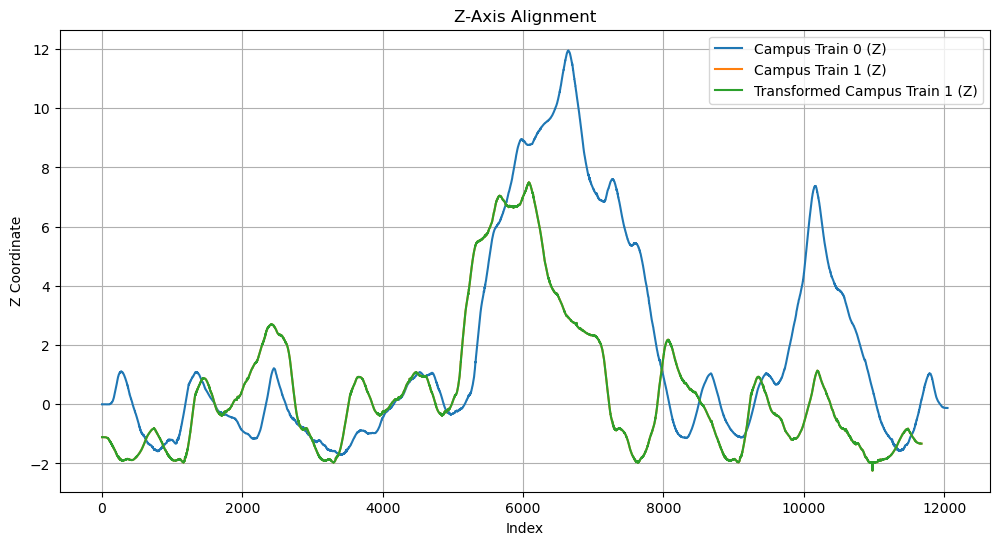

In [58]:
from my_utils.transformations import pose_to_se3, se3_to_pose
vbr_traj1 = vbr_scene_traj[:12048,:].copy()
vbr_traj2 = vbr_scene_traj[12048:,:].copy()
vbr_traj2_transformed = vbr_traj2 #np.zeros(vbr_traj2.shape)

for x in range(vbr_traj2.shape[0]):
    vbr_traj2_transformed[x,:] = se3_to_pose(np.linalg.inv(local1_to_local2) @ pose_to_se3(vbr_traj2[x,:]))

# Assuming vbr_traj1 and vbr_traj2_transformed are defined
i = 2
z1 = vbr_traj1[:, i]  # Z-coordinates of trajectory 1
z2 = vbr_traj2[:, i]  # Z-coordinates of trajectory 2
z3 = vbr_traj2_transformed[:,i]
plt.figure(figsize=(12, 6))
plt.plot(z1, label='Campus Train 0 (Z)')
plt.plot(z2, label='Campus Train 1 (Z)')
plt.plot(z3, label='Transformed Campus Train 1 (Z)')
plt.xlabel('Index')
plt.ylabel('Z Coordinate')
plt.title('Z-Axis Alignment')
plt.legend()
plt.grid(True)
plt.show()


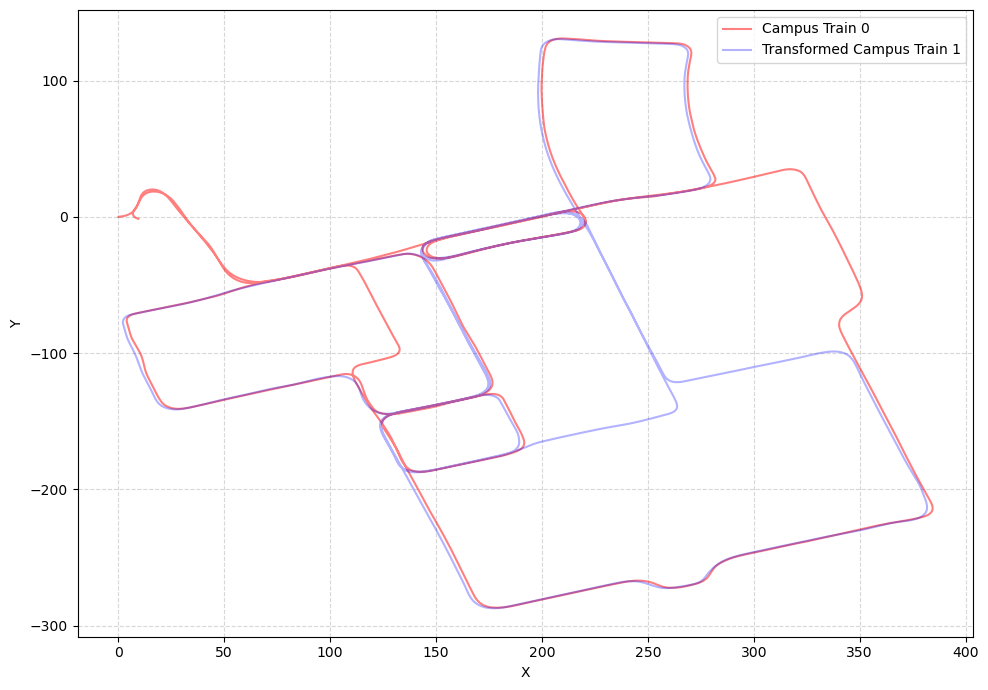

In [39]:
import matplotlib.pyplot as plt
import numpy as np

x1, y1 = vbr_traj1[:, 0], vbr_traj1[:, 1]
x2, y2 = vbr_traj2_transformed[:, 0], vbr_traj2_transformed[:, 1]
n = 500
anchor_indices = np.arange(0, len(x1), n)
query_indices = np.arange(0, len(x2), n)

plt.figure(figsize=(10, 7))
plt.plot(x1, y1, 'r-', alpha=0.5, label='Campus Train 0')
plt.plot(x2, y2, 'b-',alpha=0.3, label='Transformed Campus Train 1')

# # Scatter anchor and query markers
# plt.scatter(x1[anchor_indices], y1[anchor_indices], color='red', marker='o', s=60, label='Anchors')
# plt.scatter(x2[query_indices], y2[query_indices], color='blue', marker='x', s=60, label='Queries')

# # Annotate each anchor and query with its index (with offset and background)
# for idx in anchor_indices:
#     plt.text(x1[idx] + 2, y1[idx] + 2, str(idx), color='red', fontsize=7,
#              ha='left', va='bottom',
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

# for idx in query_indices:
#     plt.text(x2[idx] + 2, y2[idx] + 2, str(idx), color='blue', fontsize=7,
#              ha='left', va='bottom',
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# plt.title("Trajectories in X-Y Plane with Anchor and Query Markers and Indices")
plt.tight_layout()
plt.show()


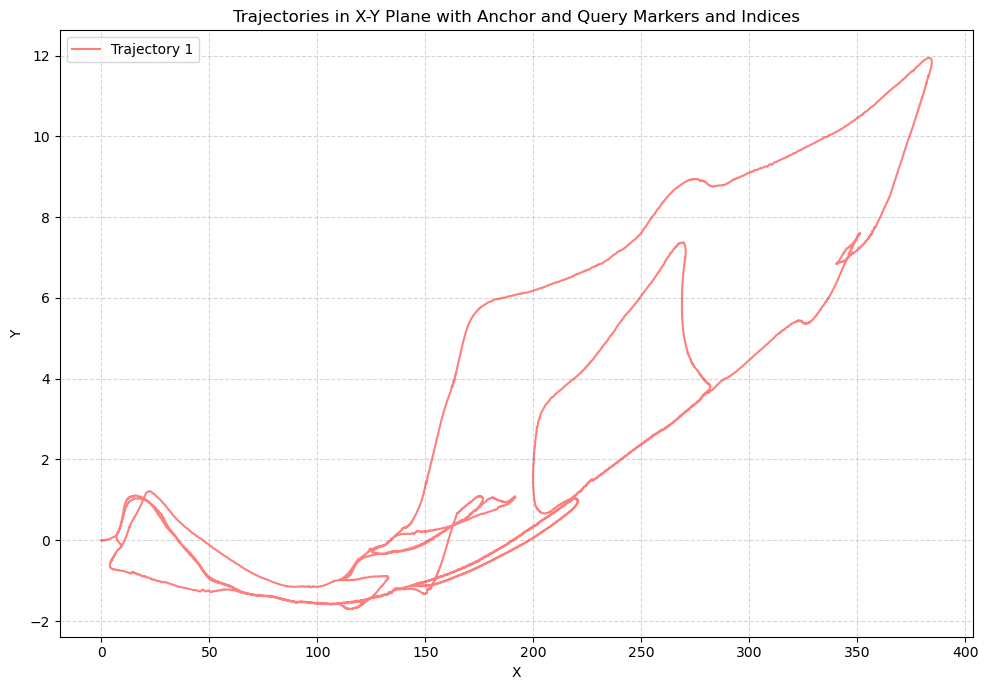

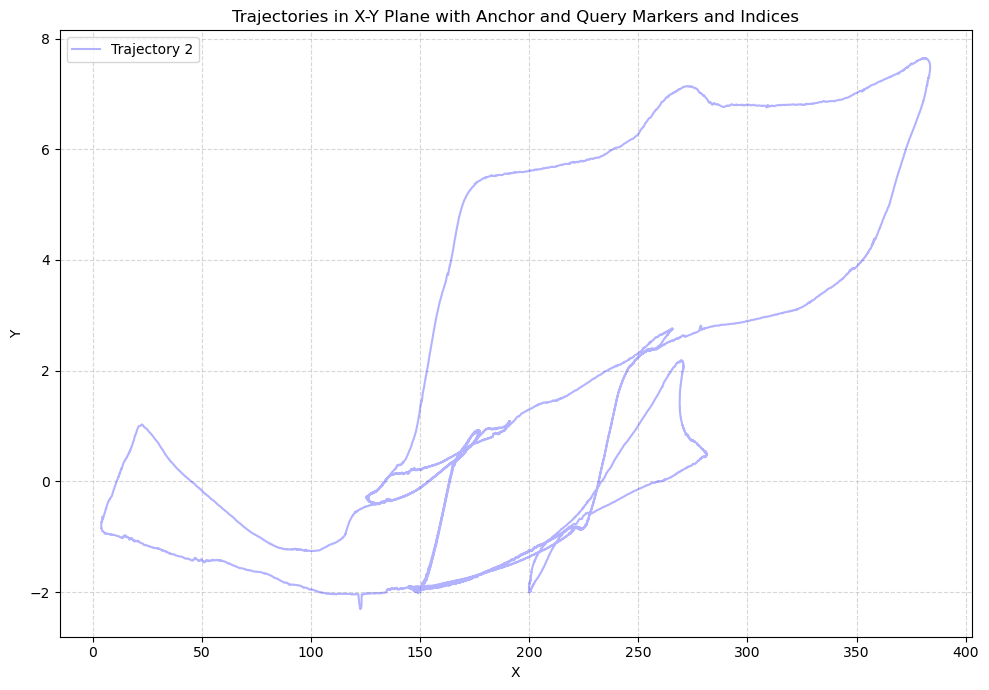

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x1, y1 = vbr_traj1[:, 0], vbr_traj1[:, 2]
x2, y2 = vbr_traj2_transformed[:, 0], vbr_traj2_transformed[:, 2]
n = 500
anchor_indices = np.arange(0, len(x1), n)
query_indices = np.arange(0, len(x2), n)

plt.figure(figsize=(10, 7))
plt.plot(x1, y1, 'r-', alpha=0.5, label='Trajectory 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Trajectories in X-Y Plane with Anchor and Query Markers and Indices")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(x2, y2, 'b-',alpha=0.3, label='Trajectory 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Trajectories in X-Y Plane with Anchor and Query Markers and Indices")
plt.tight_layout()
plt.show()


In [14]:
# import matplotlib.pyplot as plt
# import numpy as np

# # --- Trajectory 1 Plot (Anchors) ---
# plt.figure(figsize=(10, 7))
# plt.plot(x1, y1, 'r-', label='Trajectory 1')
# plt.scatter(x1[anchor_indices], y1[anchor_indices], color='green', marker='o', s=60, label='Anchors')

# # Annotate anchors
# for idx in anchor_indices:
#     plt.text(x1[idx] + 2, y1[idx] + 2, str(idx), color='green', fontsize=7,
#              ha='left', va='bottom',
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.title("Trajectory 1 with Anchor Markers and Indices")
# plt.tight_layout()
# plt.show()


# # --- Trajectory 2 Plot (Queries) ---
# plt.figure(figsize=(10, 7))
# plt.plot(x2, y2, 'b-', label='Trajectory 2')
# plt.scatter(x2[query_indices], y2[query_indices], color='purple', marker='x', s=60, label='Queries')

# # Annotate queries
# for idx in query_indices:
#     plt.text(x2[idx] + 2, y2[idx] + 2, str(idx), color='purple', fontsize=7,
#              ha='left', va='bottom',
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.title("Trajectory 2 with Query Markers and Indices")
# plt.tight_layout()
# plt.show()


In [15]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define anchor and query ranges manually
# # anchor_ranges = [(610, 3100)]  
# # query_ranges = [(3200, 3700), (9000, 11150)] 

# anchor_ranges = [(7800,8000)] 
# query_traj1_ranges = [(5000,5200)]
# query_traj2_ranges = [(4000, 5000), (1500, 2100),(9400,9600)]  

# # Extract anchor and query chunks
# anchor_chunks = [vbr_traj1[start:end] for start, end in anchor_ranges]
# query_traj1 = [vbr_traj1[start:end] for start, end in query_traj1_ranges]
# query_traj2 = [vbr_traj2_transformed[start:end] for start, end in query_traj2_ranges]


# # Plot full trajectories for context
# plt.figure(figsize=(12, 8))
# plt.plot(x1, y1, 'r-', label='Trajectory 1 (Full)', alpha=0.2)  # Full trajectory 1
# plt.plot(x2, y2, 'b-', label='Trajectory 2 (Full)', alpha=0.2)  # Full trajectory 2

# # Overlay anchor chunks
# for (start, end), chunk in zip(anchor_ranges, anchor_chunks):
#     plt.plot(chunk[:, 0], chunk[:, 1], 'g-', label=f'Anchor Sequence ({start}-{end})', linewidth=3)
#     plt.text(chunk[0, 0], chunk[0, 1], f"{start}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
#     plt.text(chunk[-1, 0], chunk[-1, 1], f"{end}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.title("Full Trajectories")
# plt.tight_layout()
# plt.show()

# # Create subplots for query chunks
# num_queries = len(query_traj2)
# fig, axes = plt.subplots(1, num_queries, figsize=(15, 5), sharex=True, sharey=True)
# for i, (chunk, (start, end)) in enumerate(zip(query_traj2, query_traj2_ranges)):
#     axes[i].plot(x2, y2, 'b-', alpha=0.2, label='Trajectory 2 (Full)')  # Full trajectory 2 for context
#     axes[i].plot(chunk[:, 0], chunk[:, 1], 'm-', label=f'Query Sequence ({start}-{end})', linewidth=3)
#     axes[i].text(chunk[0, 0], chunk[0, 1], f"{start}", color='purple', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
#     axes[i].text(chunk[-1, 0], chunk[-1, 1], f"{end}", color='purple', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
#     axes[i].set_title(f"Query Sequences from Traj2 {i+1} ({start}-{end})")
#     axes[i].set_xlabel('X')
#     axes[i].set_ylabel('Y')
#     axes[i].grid(True, linestyle='--', alpha=0.5)
#     axes[i].legend()

# plt.tight_layout()
# plt.show()

In [16]:
import json
# anchor_query_dict = {(610, 3100): [(11300, 11500), (15248, 15748), (21048, 23198)],
#                       (4000, 5000): [(5000, 5200), (16048, 17048), (13548, 14148), (21448, 21648)], 
#                       (5200, 7000): [(17048, 18548)], 
#                       (8000, 8700): [(8700, 9500), (12048, 13148), (23048, 23725), (14948, 15248)], 
#                       (9500, 10950): [(7800, 8000), (19448, 20748)]}
sequence_pairs_path = "/home/bjangley/VPR/mast3r-v2/my_vbr_utils/vbr_sequences/spagna.json"
# Load the JSON file
with open(sequence_pairs_path, 'r') as f:
    loaded_dict = json.load(f)

# Convert string keys back to tuples
anchor_query_dict = {tuple(map(int, key.strip("()").split(","))): value for key, value in loaded_dict.items()}
print(anchor_query_dict)

{(0, 2000): [[6000, 8000], [20000, 22000]], (8000, 10000): [[20000, 22000], [22000, 24000], [6000, 8000], [10000, 12000], [38000, 40000], [24000, 26000]], (40000, 42000): [[4000, 6000], [42000, 44000]], (14000, 16000): [[28000, 30000]], (26000, 28000): [[30000, 32000]]}


In [17]:
print(anchor_query_dict.keys())
print(anchor_query_dict[(0,2000)])
print(info[0]['length'])
# print(vbr_scene_traj.shape)
vbr_scene_traj = vbr_scene.get_local_trajectory()
anchor_query_dict = {(0, 2000): [[6000, 7000], [20000, 22000]], 
               (8000, 10000): [[21400, 24000],[7400, 8000], [10000, 11000], [38700, 39200]], 
               (40000, 42000): [[4000, 6000], [42000, 44000]], 
               (14000, 16000): [[28000, 30000]],
              (26000, 28000): [[30000, 32000]]}

dict_keys([(0, 2000), (8000, 10000), (40000, 42000), (14000, 16000), (26000, 28000)])
[[6000, 8000], [20000, 22000]]
12048


KeyboardInterrupt: 

In [ ]:
anchor_query_dict = {(0, 2000): [[6000, 7200], [20000, 21300]], 
               (8000, 10000): [[21400, 24000],[7400, 8000], [10000, 11000], [38700, 39200],[2000,2400]], 
               (39300, 42434): [[2500, 6000]], 
               (27000, 30200): [[14000,15000],[30200,31000]]}

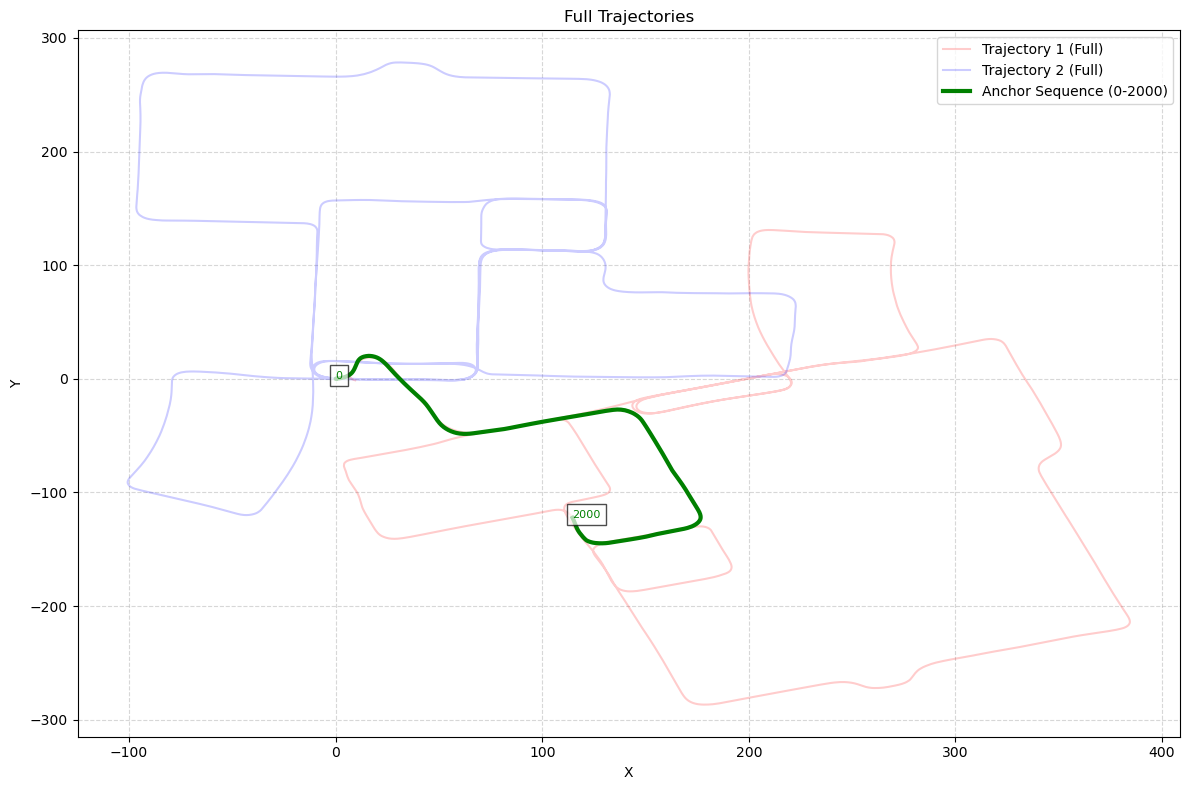

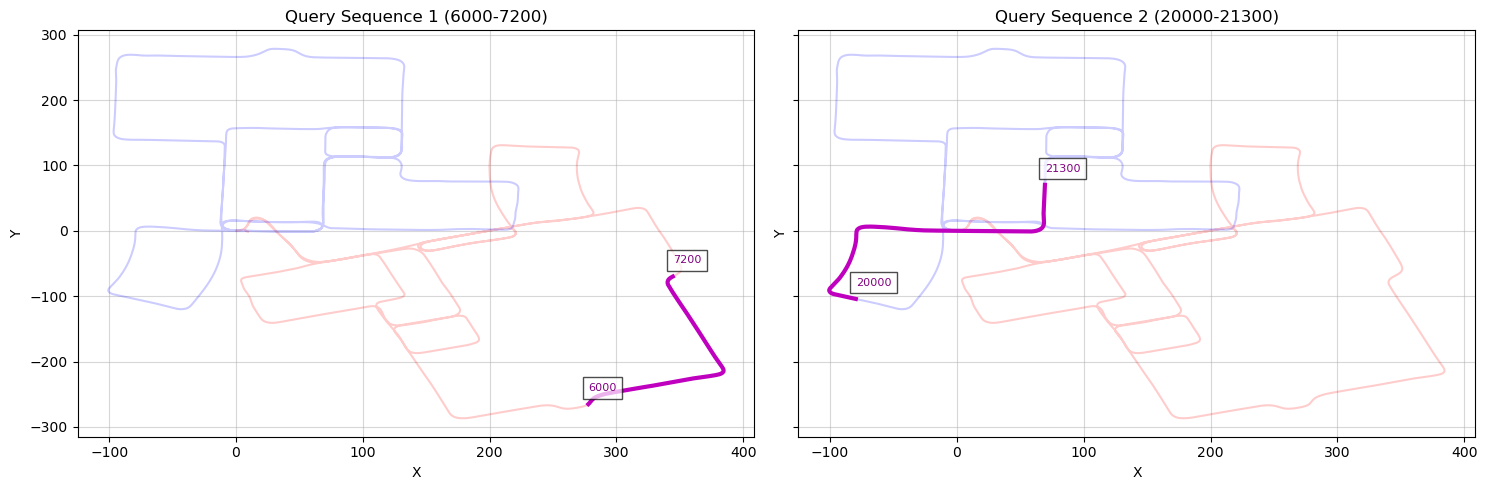

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

anchor_range = (0,2000)
query_ranges = anchor_query_dict[anchor_range]

# Extract anchor and query chunks
anchor_sequence = [vbr_scene_traj[anchor_range[0]:anchor_range[1], :]]
query_sequence = [vbr_scene_traj[start:end,:] for start, end in query_ranges]


l_train0 = info[0]['length']
x1, y1 = vbr_scene_traj[:,0], vbr_scene_traj[:,1]
# Plot full trajectories for context
plt.figure(figsize=(12, 8))
plt.plot(x1[:l_train0], y1[:l_train0], 'r-', label='Trajectory 1 (Full)', alpha=0.2)  # Full trajectory 1
plt.plot(x1[l_train0:], y1[l_train0:], 'b-', label='Trajectory 2 (Full)', alpha=0.2)  # Full trajectory 2

# Overlay anchor chunks
for chunk in anchor_sequence:
    plt.plot(chunk[:, 0], chunk[:, 1], 'g-', label=f'Anchor Sequence ({anchor_range[0]}-{anchor_range[1]})', linewidth=3)
    plt.text(chunk[0, 0], chunk[0, 1], f"{anchor_range[0]}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(chunk[-1, 0], chunk[-1, 1], f"{anchor_range[1]}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Full Trajectories")
plt.tight_layout()
plt.show()

# Create subplots for query sequences
num_queries = len(query_ranges)
cols = 2  # Number of columns for subplots
rows = (num_queries + cols - 1) // cols  # Calculate rows dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each query sequence in its own subplot
for i, (query_sequence, (start, end)) in enumerate(zip(query_sequence, query_ranges)):
    axes[i].plot(x1[:l_train0], y1[:l_train0], 'r-', label='Trajectory 1 (Full)', alpha=0.2)  # Full trajectory for context
    axes[i].plot(x1[l_train0:], y1[l_train0:], 'b-', label='Trajectory 2 (Full)', alpha=0.2)  
    axes[i].plot(query_sequence[:, 0], query_sequence[:, 1], 'm-', linewidth=3, label=f'Query ({start}-{end})')
    axes[i].text(query_sequence[0, 0], query_sequence[0, 1]+20, f"{start}", color='purple', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.7))
    axes[i].text(query_sequence[-1, 0], query_sequence[-1, 1]+20, f"{end}", color='purple', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.7))
    axes[i].set_title(f"Query Sequence {i+1} ({start}-{end})")
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    axes[i].grid(True, linestyle='-', alpha=0.5)
    # axes[i].legend()

# Hide unused subplots
for j in range(num_queries, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
all_loaded = VBRDataset(config_path, locations=['spagna'])
vbr_spagna = all_loaded.get_combined_dataset()

Loading scene: spagna_train0
  KITTI path: /datasets/vbr_slam/spagna/spagna_train0_kitti
  GT path: /datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt


KeyboardInterrupt: 

In [ ]:
import json
import numpy as np

def load_anchor_query_dict(json_file_path):
    """
    Load the anchor-query dictionary from a JSON file.
    """
    with open(json_file_path, 'r') as f:
        loaded_dict = json.load(f)

    # Convert string keys back to tuples
    anchor_query_dict = {tuple(map(int, key.strip("()").split(","))): value for key, value in loaded_dict.items()}
    return anchor_query_dict

def generate_pairs_from_ranges(anchor_query_dict, anchor_step, query_step):
    """
    Generate anchor-query index pairs from anchor and query ranges.
    """
    all_pairs = []
    for anchor_range, query_ranges in anchor_query_dict.items():
        anchor_indices = list(range(anchor_range[0], anchor_range[1], anchor_step))
        for query_range in query_ranges:
            query_indices = list(range(query_range[0], query_range[1], query_step))
            pairs = [(a, q) for a in anchor_indices for q in query_indices]
            all_pairs.extend(pairs)
    return all_pairs

# Define the path for the JSON file
json_file_path = "/home/bjangley/VPR/mast3r-v2/my_vbr_utils/vbr_sequences/campus.json"

# Load the anchor-query dictionary from the JSON file
anchor_query_dict = load_anchor_query_dict(json_file_path)

# Define anchor and query steps
anchor_step = 10
query_step = 20

# Generate the pairs
all_pairs = generate_pairs_from_ranges(anchor_query_dict, anchor_step, query_step)

# Print the first 10 pairs to verify
print(f"Generated {len(all_pairs)} pairs.")
print("First 10 pairs:")
for i in range(min(10, len(all_pairs))):
    print(all_pairs[i])

Generated 80062 pairs.
First 10 pairs:
(610, 11300)
(610, 11320)
(610, 11340)
(610, 11360)
(610, 11380)
(610, 11400)
(610, 11420)
(610, 11440)
(610, 11460)
(610, 11480)
